# Modelo RoBERTa (Robust BERT)

## Importando librerías necesarias y estableciendo parámetros globales

In [11]:
import re
import warnings
import os
import asyncio
import traceback
from utils import *
from transformers import AutoTokenizer, RobertaModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Añadiendo las librerías necesarias para el encoding de los datos.


os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

"""GLOBAL PARAMS"""
MAX_LEN = 240
TEST_SIZE = 0.2
RANDOM_STATE = 42
EPOCHS_KFOLD_FROZEN = 100
LEARNING_RATE_KFOLD_FROZEN = 3e-4
K_FOLDS_FROZEN = 2
BATCH_SIZE = 16
LOSS_FUNCTION = nn.CrossEntropyLoss()

"DIRECTORIES"
SAVE_DIRECTORY_FROZEN = "./MODELS/RoBERTa_entrenado_kfold"
SAVE_DIRECTORY_UNFROZEN = "./MODELS/RoBERTa_entrenado_kfold_unfrozen_last_layer"

TYPED_STORAGE_WARNING = re.compile(".TypedStorage is deprecated.")
FALLBACK_KERNEL_WARNING = re.compile(".Using FallbackKernel: aten.cumsum.")
TRITON_RANDOM_WARNING = re.compile(
    ".using triton random, expect difference from eager.")       


def warning_filter(message, category, filename, lineno, file=None, line=None):
    if category == UserWarning and (TYPED_STORAGE_WARNING.match(str(message)) or FALLBACK_KERNEL_WARNING.match(str(message)) or TRITON_RANDOM_WARNING.match(str(message))):
        return False  
    return True


warnings.showwarning = warning_filter
warnings.filterwarnings("ignore", category=UserWarning,
                        module="torch._inductor.ir")


# Establecer la semilla para PyTorch en las operaciones CPU
torch.manual_seed(42)

# Establecer la semilla para PyTorch en las operaciones en GPU
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(42)
%matplotlib inline
%load_ext tensorboard
%tensorboard - -logdir = ./runs - -host localhost - -port 6006

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-11-22 18:07:44.726242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 18:07:44.726359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 18:07:44.727629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
           

## Inicio entrenamiento
Primero comprobamos que la gráfica se encuentra disponible para poder usarla

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Descargamos y procesamos los datos

In [13]:
if not os.path.exists('../../data/ISEAR.csv'):
    os.system(
        'wget https://raw.githubusercontent.com/PoorvaRane/Emotion-Detector/master/ISEAR.csv -P ../../data')

# Load and preprocess the dataset
df = load_and_preprocess_data('/workspace/code/BERTS/data/ISEAR.csv')
df['Emotion'] = df['Emotion'].replace('guit', 'guilt')

In [14]:
df.head()

,Emotion,Text,Text_processed
0,joy,On days when I feel close to my partner and ot...,on days when i feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...,every time i imagine that someone i love or i ...
2,anger,When I had been obviously unjustly treated and...,when i had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...,when i think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...,at a gathering i found myself involuntarily si...


Cargamos el tokenizador para pasar las frases a tokens (unidad entendible por el modelo que vamos a estudiar)

In [15]:
 tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Tokenize and encode the input data
tokenized_features = tokenizer.batch_encode_plus(
    df['Text_processed'].values.tolist(),
    add_special_tokens=True,
    padding='max_length',
    truncation=True,
    max_length=MAX_LEN,
    return_attention_mask=True,
    return_tensors='pt'
)

In [16]:
print(tokenized_features.input_ids.shape)
print(tokenized_features.attention_mask.shape)

torch.Size([7516, 240])
torch.Size([7516, 240])


Observamos el diccionario en el que se encuentran los input_ids, es decir la codificación de cada palabra y la máscara de atención tan importante en los modelos basados en transformers.

Ahora hacemos one hot encoding de cada input_ids

In [17]:
one_hot_encoder = OneHotEncoder()
target_one_hot = one_hot_encoder.fit_transform(
    df['Emotion'].values.reshape(-1, 1)).toarray()

In [18]:
target_one_hot.shape

(7516, 7)

In [25]:
train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(
    tokenized_features["input_ids"],
    target_one_hot,
    tokenized_features["attention_mask"],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=target_one_hot,
)

In [26]:
print(train_inputs.shape, train_masks.shape, train_labels.shape)
print(test_inputs.shape, test_masks.shape, test_labels.shape)

torch.Size([6012, 240]) torch.Size([6012, 240]) (6012, 7)
torch.Size([1504, 240]) torch.Size([1504, 240]) (1504, 7)


Cargamos el modelo que vamos a usar

In [27]:
base_model = RobertaModel.from_pretrained("roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ahora congelamos las capas ya que primero vamos a hacer un entrenamiento en el que el modelo estará congelado y actuará como extractor de características. Y añadiremos una última capa de neuronas en las que si que estaremos clasificando aprovechando el token de salida.

In [28]:
for param in base_model.parameters():
    param.requires_grad = False

    # Initialize the custom RoBERTa model
model = CustomRoBERTa(base_model.to(
    device), num_classes=len(set(df['Emotion'])))

In [29]:
!nvidia-smi

Wed Nov 22 18:10:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:B7:00.0 Off |                    0 |
| N/A   29C    P0    56W / 400W |    947MiB / 40960MiB |     12%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Aprovechamos las ventajas que nos da el torch 2.0, que tiene mejoras en entrenamientos de transformers usando la función compile 

In [30]:
compiled_model = torch.compile(model)

In [31]:
optimizer = torch.optim.AdamW(
    compiled_model.parameters(), LEARNING_RATE_KFOLD_FROZEN)

Ahora vamos a utilizar el warmup, Esta función se utiliza para crear un programador de velocidad de aprendizaje lineal con fase de calentamiento (warm-up) para el entrenamiento del modelo.

In [32]:
total_steps = len(train_inputs) * EPOCHS_KFOLD_FROZEN
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps,
                                            num_training_steps=total_steps)

Procedemos a realizar el entrenamiento kfold, técnica utilizada con el fin de comprobar que nuestro modelo funciona bien ante diferentes separaciones de datos. 

In [27]:
kfold_results, model_frozen = kfold_cross_validation(train_inputs, train_labels, train_masks, compiled_model, device, EPOCHS_KFOLD_FROZEN, lr=LEARNING_RATE_KFOLD_FROZEN,
                                                     k_folds=K_FOLDS_FROZEN,
                                                     batch_size=BATCH_SIZE)

Fold 1
Training epoch 1


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.91it/s]


Epoch 1 - Average training loss: 1.96, Average training accuracy: 0.14
Epoch 1 - Average validation loss: 1.95, Average validation accuracy: 0.15
Training epoch 2


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.32it/s]


Epoch 2 - Average training loss: 1.95, Average training accuracy: 0.15
Epoch 2 - Average validation loss: 1.95, Average validation accuracy: 0.17
Training epoch 3


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.71it/s]


Epoch 3 - Average training loss: 1.95, Average training accuracy: 0.17
Epoch 3 - Average validation loss: 1.94, Average validation accuracy: 0.14
Training epoch 4


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.34it/s]


Epoch 4 - Average training loss: 1.94, Average training accuracy: 0.17
Epoch 4 - Average validation loss: 1.94, Average validation accuracy: 0.15
Training epoch 5


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.21it/s]


Epoch 5 - Average training loss: 1.93, Average training accuracy: 0.20
Epoch 5 - Average validation loss: 1.93, Average validation accuracy: 0.14
Training epoch 6


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.39it/s]


Epoch 6 - Average training loss: 1.93, Average training accuracy: 0.23
Epoch 6 - Average validation loss: 1.93, Average validation accuracy: 0.30
Training epoch 7


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.39it/s]


Epoch 7 - Average training loss: 1.92, Average training accuracy: 0.27
Epoch 7 - Average validation loss: 1.92, Average validation accuracy: 0.31
Training epoch 8


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.31it/s]


Epoch 8 - Average training loss: 1.91, Average training accuracy: 0.28
Epoch 8 - Average validation loss: 1.91, Average validation accuracy: 0.23
Training epoch 9


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.30it/s]


Epoch 9 - Average training loss: 1.91, Average training accuracy: 0.29
Epoch 9 - Average validation loss: 1.90, Average validation accuracy: 0.31
Training epoch 10


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.35it/s]


Epoch 10 - Average training loss: 1.90, Average training accuracy: 0.31
Epoch 10 - Average validation loss: 1.89, Average validation accuracy: 0.35
Training epoch 11


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.36it/s]


Epoch 11 - Average training loss: 1.89, Average training accuracy: 0.32
Epoch 11 - Average validation loss: 1.88, Average validation accuracy: 0.34
Training epoch 12


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.41it/s]


Epoch 12 - Average training loss: 1.87, Average training accuracy: 0.36
Epoch 12 - Average validation loss: 1.88, Average validation accuracy: 0.36
Training epoch 13


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.45it/s]


Epoch 13 - Average training loss: 1.87, Average training accuracy: 0.36
Epoch 13 - Average validation loss: 1.87, Average validation accuracy: 0.37
Training epoch 14


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.30it/s]


Epoch 14 - Average training loss: 1.86, Average training accuracy: 0.38
Epoch 14 - Average validation loss: 1.86, Average validation accuracy: 0.42
Training epoch 15


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.07it/s]


Epoch 15 - Average training loss: 1.85, Average training accuracy: 0.38
Epoch 15 - Average validation loss: 1.85, Average validation accuracy: 0.39
Training epoch 16


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.72it/s]


Epoch 16 - Average training loss: 1.84, Average training accuracy: 0.39
Epoch 16 - Average validation loss: 1.84, Average validation accuracy: 0.39
Training epoch 17


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.38it/s]


Epoch 17 - Average training loss: 1.83, Average training accuracy: 0.40
Epoch 17 - Average validation loss: 1.83, Average validation accuracy: 0.42
Training epoch 18


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.86it/s]


Epoch 18 - Average training loss: 1.83, Average training accuracy: 0.40
Epoch 18 - Average validation loss: 1.83, Average validation accuracy: 0.43
Training epoch 19


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.84it/s]


Epoch 19 - Average training loss: 1.81, Average training accuracy: 0.41
Epoch 19 - Average validation loss: 1.82, Average validation accuracy: 0.43
Training epoch 20


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.83it/s]


Epoch 20 - Average training loss: 1.81, Average training accuracy: 0.42
Epoch 20 - Average validation loss: 1.81, Average validation accuracy: 0.43
Training epoch 21


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.82it/s]


Epoch 21 - Average training loss: 1.80, Average training accuracy: 0.42
Epoch 21 - Average validation loss: 1.81, Average validation accuracy: 0.43
Training epoch 22


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.55it/s]


Epoch 22 - Average training loss: 1.79, Average training accuracy: 0.43
Epoch 22 - Average validation loss: 1.80, Average validation accuracy: 0.44
Training epoch 23


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.24it/s]


Epoch 23 - Average training loss: 1.79, Average training accuracy: 0.43
Epoch 23 - Average validation loss: 1.79, Average validation accuracy: 0.44
Training epoch 24


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.32it/s]


Epoch 24 - Average training loss: 1.78, Average training accuracy: 0.43
Epoch 24 - Average validation loss: 1.79, Average validation accuracy: 0.45
Training epoch 25


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.39it/s]


Epoch 25 - Average training loss: 1.78, Average training accuracy: 0.44
Epoch 25 - Average validation loss: 1.78, Average validation accuracy: 0.45
Training epoch 26


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.42it/s]


Epoch 26 - Average training loss: 1.77, Average training accuracy: 0.45
Epoch 26 - Average validation loss: 1.78, Average validation accuracy: 0.45
Training epoch 27


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.35it/s]


Epoch 27 - Average training loss: 1.77, Average training accuracy: 0.43
Epoch 27 - Average validation loss: 1.77, Average validation accuracy: 0.46
Training epoch 28


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.71it/s]


Epoch 28 - Average training loss: 1.76, Average training accuracy: 0.45
Epoch 28 - Average validation loss: 1.76, Average validation accuracy: 0.46
Training epoch 29


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.38it/s]


Epoch 29 - Average training loss: 1.75, Average training accuracy: 0.45
Epoch 29 - Average validation loss: 1.76, Average validation accuracy: 0.46
Training epoch 30


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.40it/s]


Epoch 30 - Average training loss: 1.75, Average training accuracy: 0.46
Epoch 30 - Average validation loss: 1.75, Average validation accuracy: 0.47
Training epoch 31


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.40it/s]


Epoch 31 - Average training loss: 1.75, Average training accuracy: 0.45
Epoch 31 - Average validation loss: 1.75, Average validation accuracy: 0.47
Training epoch 32


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.51it/s]


Epoch 32 - Average training loss: 1.74, Average training accuracy: 0.45
Epoch 32 - Average validation loss: 1.74, Average validation accuracy: 0.46
Training epoch 33


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.44it/s]


Epoch 33 - Average training loss: 1.73, Average training accuracy: 0.45
Epoch 33 - Average validation loss: 1.74, Average validation accuracy: 0.47
Training epoch 34


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.53it/s]


Epoch 34 - Average training loss: 1.73, Average training accuracy: 0.45
Epoch 34 - Average validation loss: 1.74, Average validation accuracy: 0.47
Training epoch 35


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.35it/s]


Epoch 35 - Average training loss: 1.73, Average training accuracy: 0.46
Epoch 35 - Average validation loss: 1.73, Average validation accuracy: 0.47
Training epoch 36


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.35it/s]


Epoch 36 - Average training loss: 1.72, Average training accuracy: 0.46
Epoch 36 - Average validation loss: 1.73, Average validation accuracy: 0.46
Training epoch 37


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.33it/s]


Epoch 37 - Average training loss: 1.71, Average training accuracy: 0.46
Epoch 37 - Average validation loss: 1.72, Average validation accuracy: 0.48
Training epoch 38


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.22it/s]


Epoch 38 - Average training loss: 1.71, Average training accuracy: 0.47
Epoch 38 - Average validation loss: 1.72, Average validation accuracy: 0.48
Training epoch 39


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.26it/s]


Epoch 39 - Average training loss: 1.71, Average training accuracy: 0.47
Epoch 39 - Average validation loss: 1.71, Average validation accuracy: 0.49
Training epoch 40


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.09it/s]


Epoch 40 - Average training loss: 1.70, Average training accuracy: 0.47
Epoch 40 - Average validation loss: 1.71, Average validation accuracy: 0.49
Training epoch 41


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.25it/s]


Epoch 41 - Average training loss: 1.71, Average training accuracy: 0.45
Epoch 41 - Average validation loss: 1.71, Average validation accuracy: 0.49
Training epoch 42


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.19it/s]


Epoch 42 - Average training loss: 1.70, Average training accuracy: 0.46
Epoch 42 - Average validation loss: 1.70, Average validation accuracy: 0.49
Training epoch 43


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.98it/s]


Epoch 43 - Average training loss: 1.70, Average training accuracy: 0.47
Epoch 43 - Average validation loss: 1.70, Average validation accuracy: 0.49
Training epoch 44


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.03it/s]


Epoch 44 - Average training loss: 1.69, Average training accuracy: 0.47
Epoch 44 - Average validation loss: 1.70, Average validation accuracy: 0.49
Training epoch 45


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.75it/s]


Epoch 45 - Average training loss: 1.69, Average training accuracy: 0.47
Epoch 45 - Average validation loss: 1.69, Average validation accuracy: 0.49
Training epoch 46


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.83it/s]


Epoch 46 - Average training loss: 1.69, Average training accuracy: 0.48
Epoch 46 - Average validation loss: 1.69, Average validation accuracy: 0.49
Training epoch 47


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.15it/s]


Epoch 47 - Average training loss: 1.68, Average training accuracy: 0.48
Epoch 47 - Average validation loss: 1.68, Average validation accuracy: 0.50
Training epoch 48


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.36it/s]


Epoch 48 - Average training loss: 1.68, Average training accuracy: 0.48
Epoch 48 - Average validation loss: 1.68, Average validation accuracy: 0.50
Training epoch 49


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.23it/s]


Epoch 49 - Average training loss: 1.67, Average training accuracy: 0.48
Epoch 49 - Average validation loss: 1.68, Average validation accuracy: 0.50
Training epoch 50


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.35it/s]


Epoch 50 - Average training loss: 1.68, Average training accuracy: 0.48
Epoch 50 - Average validation loss: 1.68, Average validation accuracy: 0.50
Training epoch 51


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.96it/s]


Epoch 51 - Average training loss: 1.67, Average training accuracy: 0.48
Epoch 51 - Average validation loss: 1.67, Average validation accuracy: 0.50
Training epoch 52


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.16it/s]


Epoch 52 - Average training loss: 1.66, Average training accuracy: 0.49
Epoch 52 - Average validation loss: 1.67, Average validation accuracy: 0.50
Training epoch 53


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.06it/s]


Epoch 53 - Average training loss: 1.67, Average training accuracy: 0.47
Epoch 53 - Average validation loss: 1.67, Average validation accuracy: 0.50
Training epoch 54


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.14it/s]


Epoch 54 - Average training loss: 1.66, Average training accuracy: 0.48
Epoch 54 - Average validation loss: 1.66, Average validation accuracy: 0.51
Training epoch 55


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.19it/s]


Epoch 55 - Average training loss: 1.66, Average training accuracy: 0.48
Epoch 55 - Average validation loss: 1.66, Average validation accuracy: 0.51
Training epoch 56


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.33it/s]


Epoch 56 - Average training loss: 1.65, Average training accuracy: 0.48
Epoch 56 - Average validation loss: 1.66, Average validation accuracy: 0.51
Training epoch 57


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.30it/s]


Epoch 57 - Average training loss: 1.65, Average training accuracy: 0.49
Epoch 57 - Average validation loss: 1.66, Average validation accuracy: 0.50
Training epoch 58


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.37it/s]


Epoch 58 - Average training loss: 1.64, Average training accuracy: 0.48
Epoch 58 - Average validation loss: 1.66, Average validation accuracy: 0.50
Training epoch 59


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.40it/s]


Epoch 59 - Average training loss: 1.66, Average training accuracy: 0.48
Epoch 59 - Average validation loss: 1.65, Average validation accuracy: 0.51
Training epoch 60


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.30it/s]


Epoch 60 - Average training loss: 1.65, Average training accuracy: 0.49
Epoch 60 - Average validation loss: 1.65, Average validation accuracy: 0.51
Training epoch 61


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.14it/s]


Epoch 61 - Average training loss: 1.64, Average training accuracy: 0.48
Epoch 61 - Average validation loss: 1.65, Average validation accuracy: 0.51
Training epoch 62


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.22it/s]


Epoch 62 - Average training loss: 1.64, Average training accuracy: 0.49
Epoch 62 - Average validation loss: 1.65, Average validation accuracy: 0.51
Training epoch 63


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.05it/s]


Epoch 63 - Average training loss: 1.64, Average training accuracy: 0.48
Epoch 63 - Average validation loss: 1.65, Average validation accuracy: 0.50
Training epoch 64


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.38it/s]


Epoch 64 - Average training loss: 1.64, Average training accuracy: 0.48
Epoch 64 - Average validation loss: 1.64, Average validation accuracy: 0.51
Training epoch 65


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.39it/s]


Epoch 65 - Average training loss: 1.64, Average training accuracy: 0.48
Epoch 65 - Average validation loss: 1.64, Average validation accuracy: 0.51
Training epoch 66


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.43it/s]


Epoch 66 - Average training loss: 1.64, Average training accuracy: 0.50
Epoch 66 - Average validation loss: 1.64, Average validation accuracy: 0.51
Training epoch 67


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.39it/s]


Epoch 67 - Average training loss: 1.64, Average training accuracy: 0.48
Epoch 67 - Average validation loss: 1.64, Average validation accuracy: 0.51
Training epoch 68


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.26it/s]


Epoch 68 - Average training loss: 1.63, Average training accuracy: 0.49
Epoch 68 - Average validation loss: 1.64, Average validation accuracy: 0.51
Training epoch 69


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.44it/s]


Epoch 69 - Average training loss: 1.64, Average training accuracy: 0.48
Epoch 69 - Average validation loss: 1.63, Average validation accuracy: 0.52
Training epoch 70


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.51it/s]


Epoch 70 - Average training loss: 1.63, Average training accuracy: 0.49
Epoch 70 - Average validation loss: 1.63, Average validation accuracy: 0.51
Training epoch 71


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.44it/s]


Epoch 71 - Average training loss: 1.63, Average training accuracy: 0.49
Epoch 71 - Average validation loss: 1.63, Average validation accuracy: 0.51
Training epoch 72


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.34it/s]


Epoch 72 - Average training loss: 1.63, Average training accuracy: 0.50
Epoch 72 - Average validation loss: 1.63, Average validation accuracy: 0.51
Training epoch 73


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.30it/s]


Epoch 73 - Average training loss: 1.63, Average training accuracy: 0.48
Epoch 73 - Average validation loss: 1.63, Average validation accuracy: 0.51
Training epoch 74


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.27it/s]


Epoch 74 - Average training loss: 1.63, Average training accuracy: 0.48
Epoch 74 - Average validation loss: 1.63, Average validation accuracy: 0.51
Training epoch 75


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.28it/s]


Epoch 75 - Average training loss: 1.63, Average training accuracy: 0.49
Epoch 75 - Average validation loss: 1.63, Average validation accuracy: 0.52
Training epoch 76


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.30it/s]


Epoch 76 - Average training loss: 1.62, Average training accuracy: 0.49
Epoch 76 - Average validation loss: 1.62, Average validation accuracy: 0.51
Training epoch 77


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.35it/s]


Epoch 77 - Average training loss: 1.63, Average training accuracy: 0.49
Epoch 77 - Average validation loss: 1.62, Average validation accuracy: 0.51
Training epoch 78


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.41it/s]


Epoch 78 - Average training loss: 1.63, Average training accuracy: 0.49
Epoch 78 - Average validation loss: 1.62, Average validation accuracy: 0.52
Training epoch 79


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.48it/s]


Epoch 79 - Average training loss: 1.62, Average training accuracy: 0.49
Epoch 79 - Average validation loss: 1.62, Average validation accuracy: 0.52
Training epoch 80


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.42it/s]


Epoch 80 - Average training loss: 1.62, Average training accuracy: 0.48
Epoch 80 - Average validation loss: 1.62, Average validation accuracy: 0.52
Training epoch 81


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.41it/s]


Epoch 81 - Average training loss: 1.62, Average training accuracy: 0.50
Epoch 81 - Average validation loss: 1.62, Average validation accuracy: 0.52
Training epoch 82


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.41it/s]


Epoch 82 - Average training loss: 1.62, Average training accuracy: 0.49
Epoch 82 - Average validation loss: 1.62, Average validation accuracy: 0.52
Training epoch 83


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.42it/s]


Epoch 83 - Average training loss: 1.61, Average training accuracy: 0.49
Epoch 83 - Average validation loss: 1.62, Average validation accuracy: 0.52
Training epoch 84


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.43it/s]


Epoch 84 - Average training loss: 1.62, Average training accuracy: 0.50
Epoch 84 - Average validation loss: 1.62, Average validation accuracy: 0.52
Training epoch 85


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.23it/s]


Epoch 85 - Average training loss: 1.62, Average training accuracy: 0.49
Epoch 85 - Average validation loss: 1.62, Average validation accuracy: 0.52
Training epoch 86


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.46it/s]


Epoch 86 - Average training loss: 1.61, Average training accuracy: 0.49
Epoch 86 - Average validation loss: 1.62, Average validation accuracy: 0.52
Training epoch 87


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.50it/s]


Epoch 87 - Average training loss: 1.62, Average training accuracy: 0.49
Epoch 87 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 88


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.36it/s]


Epoch 88 - Average training loss: 1.62, Average training accuracy: 0.49
Epoch 88 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 89


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.44it/s]


Epoch 89 - Average training loss: 1.61, Average training accuracy: 0.50
Epoch 89 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 90


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.45it/s]


Epoch 90 - Average training loss: 1.61, Average training accuracy: 0.49
Epoch 90 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 91


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.44it/s]


Epoch 91 - Average training loss: 1.61, Average training accuracy: 0.49
Epoch 91 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 92


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.45it/s]


Epoch 92 - Average training loss: 1.61, Average training accuracy: 0.50
Epoch 92 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 93


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.41it/s]


Epoch 93 - Average training loss: 1.61, Average training accuracy: 0.50
Epoch 93 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 94


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.46it/s]


Epoch 94 - Average training loss: 1.61, Average training accuracy: 0.51
Epoch 94 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 95


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.36it/s]


Epoch 95 - Average training loss: 1.61, Average training accuracy: 0.49
Epoch 95 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 96


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.88it/s]


Epoch 96 - Average training loss: 1.61, Average training accuracy: 0.49
Epoch 96 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 97


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.24it/s]


Epoch 97 - Average training loss: 1.61, Average training accuracy: 0.49
Epoch 97 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 98


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.37it/s]


Epoch 98 - Average training loss: 1.61, Average training accuracy: 0.49
Epoch 98 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 99


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.40it/s]


Epoch 99 - Average training loss: 1.62, Average training accuracy: 0.50
Epoch 99 - Average validation loss: 1.61, Average validation accuracy: 0.52
Training epoch 100


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.44it/s]


Epoch 100 - Average training loss: 1.60, Average training accuracy: 0.50
Epoch 100 - Average validation loss: 1.61, Average validation accuracy: 0.52
Fold 2
Training epoch 1


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:23<00:00,  7.98it/s]


Epoch 1 - Average training loss: 1.96, Average training accuracy: 0.15
Epoch 1 - Average validation loss: 1.95, Average validation accuracy: 0.14
Training epoch 2


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.15it/s]


Epoch 2 - Average training loss: 1.95, Average training accuracy: 0.16
Epoch 2 - Average validation loss: 1.94, Average validation accuracy: 0.14
Training epoch 3


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.19it/s]


Epoch 3 - Average training loss: 1.94, Average training accuracy: 0.16
Epoch 3 - Average validation loss: 1.94, Average validation accuracy: 0.16
Training epoch 4


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.22it/s]


Epoch 4 - Average training loss: 1.94, Average training accuracy: 0.17
Epoch 4 - Average validation loss: 1.94, Average validation accuracy: 0.21
Training epoch 5


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.16it/s]


Epoch 5 - Average training loss: 1.93, Average training accuracy: 0.22
Epoch 5 - Average validation loss: 1.93, Average validation accuracy: 0.24
Training epoch 6


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.04it/s]


Epoch 6 - Average training loss: 1.93, Average training accuracy: 0.24
Epoch 6 - Average validation loss: 1.93, Average validation accuracy: 0.29
Training epoch 7


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.10it/s]


Epoch 7 - Average training loss: 1.92, Average training accuracy: 0.28
Epoch 7 - Average validation loss: 1.92, Average validation accuracy: 0.29
Training epoch 8


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.08it/s]


Epoch 8 - Average training loss: 1.91, Average training accuracy: 0.32
Epoch 8 - Average validation loss: 1.91, Average validation accuracy: 0.35
Training epoch 9


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.10it/s]


Epoch 9 - Average training loss: 1.90, Average training accuracy: 0.34
Epoch 9 - Average validation loss: 1.90, Average validation accuracy: 0.36
Training epoch 10


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.00it/s]


Epoch 10 - Average training loss: 1.89, Average training accuracy: 0.36
Epoch 10 - Average validation loss: 1.89, Average validation accuracy: 0.36
Training epoch 11


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.94it/s]


Epoch 11 - Average training loss: 1.88, Average training accuracy: 0.38
Epoch 11 - Average validation loss: 1.88, Average validation accuracy: 0.39
Training epoch 12


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.04it/s]


Epoch 12 - Average training loss: 1.87, Average training accuracy: 0.38
Epoch 12 - Average validation loss: 1.88, Average validation accuracy: 0.39
Training epoch 13


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.10it/s]


Epoch 13 - Average training loss: 1.86, Average training accuracy: 0.40
Epoch 13 - Average validation loss: 1.87, Average validation accuracy: 0.44
Training epoch 14


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.12it/s]


Epoch 14 - Average training loss: 1.85, Average training accuracy: 0.41
Epoch 14 - Average validation loss: 1.86, Average validation accuracy: 0.44
Training epoch 15


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.12it/s]


Epoch 15 - Average training loss: 1.84, Average training accuracy: 0.40
Epoch 15 - Average validation loss: 1.85, Average validation accuracy: 0.43
Training epoch 16


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.15it/s]


Epoch 16 - Average training loss: 1.83, Average training accuracy: 0.42
Epoch 16 - Average validation loss: 1.84, Average validation accuracy: 0.46
Training epoch 17


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.10it/s]


Epoch 17 - Average training loss: 1.82, Average training accuracy: 0.43
Epoch 17 - Average validation loss: 1.83, Average validation accuracy: 0.45
Training epoch 18


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.14it/s]


Epoch 18 - Average training loss: 1.82, Average training accuracy: 0.43
Epoch 18 - Average validation loss: 1.83, Average validation accuracy: 0.47
Training epoch 19


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.18it/s]


Epoch 19 - Average training loss: 1.80, Average training accuracy: 0.45
Epoch 19 - Average validation loss: 1.82, Average validation accuracy: 0.46
Training epoch 20


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.25it/s]


Epoch 20 - Average training loss: 1.80, Average training accuracy: 0.45
Epoch 20 - Average validation loss: 1.81, Average validation accuracy: 0.47
Training epoch 21


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.18it/s]


Epoch 21 - Average training loss: 1.79, Average training accuracy: 0.44
Epoch 21 - Average validation loss: 1.81, Average validation accuracy: 0.46
Training epoch 22


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.12it/s]


Epoch 22 - Average training loss: 1.78, Average training accuracy: 0.45
Epoch 22 - Average validation loss: 1.80, Average validation accuracy: 0.47
Training epoch 23


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.23it/s]


Epoch 23 - Average training loss: 1.77, Average training accuracy: 0.46
Epoch 23 - Average validation loss: 1.79, Average validation accuracy: 0.47
Training epoch 24


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.19it/s]


Epoch 24 - Average training loss: 1.77, Average training accuracy: 0.46
Epoch 24 - Average validation loss: 1.79, Average validation accuracy: 0.48
Training epoch 25


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.23it/s]


Epoch 25 - Average training loss: 1.76, Average training accuracy: 0.45
Epoch 25 - Average validation loss: 1.78, Average validation accuracy: 0.48
Training epoch 26


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.24it/s]


Epoch 26 - Average training loss: 1.76, Average training accuracy: 0.45
Epoch 26 - Average validation loss: 1.77, Average validation accuracy: 0.48
Training epoch 27


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.23it/s]


Epoch 27 - Average training loss: 1.74, Average training accuracy: 0.46
Epoch 27 - Average validation loss: 1.77, Average validation accuracy: 0.48
Training epoch 28


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.21it/s]


Epoch 28 - Average training loss: 1.74, Average training accuracy: 0.46
Epoch 28 - Average validation loss: 1.76, Average validation accuracy: 0.49
Training epoch 29


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.22it/s]


Epoch 29 - Average training loss: 1.74, Average training accuracy: 0.46
Epoch 29 - Average validation loss: 1.76, Average validation accuracy: 0.49
Training epoch 30


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.17it/s]


Epoch 30 - Average training loss: 1.73, Average training accuracy: 0.47
Epoch 30 - Average validation loss: 1.75, Average validation accuracy: 0.49
Training epoch 31


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.12it/s]


Epoch 31 - Average training loss: 1.73, Average training accuracy: 0.47
Epoch 31 - Average validation loss: 1.75, Average validation accuracy: 0.49
Training epoch 32


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.99it/s]


Epoch 32 - Average training loss: 1.72, Average training accuracy: 0.47
Epoch 32 - Average validation loss: 1.74, Average validation accuracy: 0.49
Training epoch 33


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.08it/s]


Epoch 33 - Average training loss: 1.72, Average training accuracy: 0.48
Epoch 33 - Average validation loss: 1.74, Average validation accuracy: 0.49
Training epoch 34


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.92it/s]


Epoch 34 - Average training loss: 1.71, Average training accuracy: 0.47
Epoch 34 - Average validation loss: 1.73, Average validation accuracy: 0.49
Training epoch 35


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.11it/s]


Epoch 35 - Average training loss: 1.70, Average training accuracy: 0.48
Epoch 35 - Average validation loss: 1.73, Average validation accuracy: 0.50
Training epoch 36


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.71it/s]


Epoch 36 - Average training loss: 1.70, Average training accuracy: 0.48
Epoch 36 - Average validation loss: 1.73, Average validation accuracy: 0.51
Training epoch 37


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.73it/s]


Epoch 37 - Average training loss: 1.70, Average training accuracy: 0.47
Epoch 37 - Average validation loss: 1.72, Average validation accuracy: 0.51
Training epoch 38


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.14it/s]


Epoch 38 - Average training loss: 1.69, Average training accuracy: 0.48
Epoch 38 - Average validation loss: 1.72, Average validation accuracy: 0.51
Training epoch 39


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.26it/s]


Epoch 39 - Average training loss: 1.69, Average training accuracy: 0.48
Epoch 39 - Average validation loss: 1.71, Average validation accuracy: 0.51
Training epoch 40


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.33it/s]


Epoch 40 - Average training loss: 1.68, Average training accuracy: 0.49
Epoch 40 - Average validation loss: 1.71, Average validation accuracy: 0.51
Training epoch 41


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.28it/s]


Epoch 41 - Average training loss: 1.68, Average training accuracy: 0.48
Epoch 41 - Average validation loss: 1.71, Average validation accuracy: 0.51
Training epoch 42


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.28it/s]


Epoch 42 - Average training loss: 1.68, Average training accuracy: 0.48
Epoch 42 - Average validation loss: 1.70, Average validation accuracy: 0.51
Training epoch 43


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.20it/s]


Epoch 43 - Average training loss: 1.68, Average training accuracy: 0.50
Epoch 43 - Average validation loss: 1.70, Average validation accuracy: 0.51
Training epoch 44


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.28it/s]


Epoch 44 - Average training loss: 1.68, Average training accuracy: 0.48
Epoch 44 - Average validation loss: 1.70, Average validation accuracy: 0.51
Training epoch 45


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.22it/s]


Epoch 45 - Average training loss: 1.67, Average training accuracy: 0.48
Epoch 45 - Average validation loss: 1.69, Average validation accuracy: 0.51
Training epoch 46


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.19it/s]


Epoch 46 - Average training loss: 1.66, Average training accuracy: 0.49
Epoch 46 - Average validation loss: 1.69, Average validation accuracy: 0.52
Training epoch 47


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.25it/s]


Epoch 47 - Average training loss: 1.67, Average training accuracy: 0.48
Epoch 47 - Average validation loss: 1.69, Average validation accuracy: 0.52
Training epoch 48


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.17it/s]


Epoch 48 - Average training loss: 1.66, Average training accuracy: 0.49
Epoch 48 - Average validation loss: 1.68, Average validation accuracy: 0.51
Training epoch 49


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.27it/s]


Epoch 49 - Average training loss: 1.66, Average training accuracy: 0.48
Epoch 49 - Average validation loss: 1.68, Average validation accuracy: 0.51
Training epoch 50


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.18it/s]


Epoch 50 - Average training loss: 1.66, Average training accuracy: 0.49
Epoch 50 - Average validation loss: 1.68, Average validation accuracy: 0.51
Training epoch 51


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.27it/s]


Epoch 51 - Average training loss: 1.64, Average training accuracy: 0.50
Epoch 51 - Average validation loss: 1.67, Average validation accuracy: 0.52
Training epoch 52


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.24it/s]


Epoch 52 - Average training loss: 1.64, Average training accuracy: 0.49
Epoch 52 - Average validation loss: 1.67, Average validation accuracy: 0.51
Training epoch 53


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.23it/s]


Epoch 53 - Average training loss: 1.64, Average training accuracy: 0.49
Epoch 53 - Average validation loss: 1.67, Average validation accuracy: 0.52
Training epoch 54


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.23it/s]


Epoch 54 - Average training loss: 1.64, Average training accuracy: 0.49
Epoch 54 - Average validation loss: 1.67, Average validation accuracy: 0.51
Training epoch 55


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.19it/s]


Epoch 55 - Average training loss: 1.64, Average training accuracy: 0.49
Epoch 55 - Average validation loss: 1.66, Average validation accuracy: 0.51
Training epoch 56


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.16it/s]


Epoch 56 - Average training loss: 1.64, Average training accuracy: 0.50
Epoch 56 - Average validation loss: 1.66, Average validation accuracy: 0.52
Training epoch 57


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.21it/s]


Epoch 57 - Average training loss: 1.64, Average training accuracy: 0.49
Epoch 57 - Average validation loss: 1.66, Average validation accuracy: 0.52
Training epoch 58


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.04it/s]


Epoch 58 - Average training loss: 1.63, Average training accuracy: 0.50
Epoch 58 - Average validation loss: 1.66, Average validation accuracy: 0.52
Training epoch 59


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.08it/s]


Epoch 59 - Average training loss: 1.62, Average training accuracy: 0.50
Epoch 59 - Average validation loss: 1.65, Average validation accuracy: 0.52
Training epoch 60


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.51it/s]


Epoch 60 - Average training loss: 1.63, Average training accuracy: 0.49
Epoch 60 - Average validation loss: 1.65, Average validation accuracy: 0.52
Training epoch 61


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.03it/s]


Epoch 61 - Average training loss: 1.63, Average training accuracy: 0.49
Epoch 61 - Average validation loss: 1.65, Average validation accuracy: 0.52
Training epoch 62


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.05it/s]


Epoch 62 - Average training loss: 1.62, Average training accuracy: 0.50
Epoch 62 - Average validation loss: 1.65, Average validation accuracy: 0.52
Training epoch 63


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.13it/s]


Epoch 63 - Average training loss: 1.62, Average training accuracy: 0.50
Epoch 63 - Average validation loss: 1.65, Average validation accuracy: 0.52
Training epoch 64


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.04it/s]


Epoch 64 - Average training loss: 1.63, Average training accuracy: 0.49
Epoch 64 - Average validation loss: 1.64, Average validation accuracy: 0.52
Training epoch 65


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.02it/s]


Epoch 65 - Average training loss: 1.62, Average training accuracy: 0.50
Epoch 65 - Average validation loss: 1.64, Average validation accuracy: 0.52
Training epoch 66


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.99it/s]


Epoch 66 - Average training loss: 1.62, Average training accuracy: 0.50
Epoch 66 - Average validation loss: 1.64, Average validation accuracy: 0.53
Training epoch 67


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.02it/s]


Epoch 67 - Average training loss: 1.61, Average training accuracy: 0.50
Epoch 67 - Average validation loss: 1.64, Average validation accuracy: 0.53
Training epoch 68


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.06it/s]


Epoch 68 - Average training loss: 1.61, Average training accuracy: 0.51
Epoch 68 - Average validation loss: 1.64, Average validation accuracy: 0.53
Training epoch 69


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.01it/s]


Epoch 69 - Average training loss: 1.61, Average training accuracy: 0.50
Epoch 69 - Average validation loss: 1.64, Average validation accuracy: 0.52
Training epoch 70


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.05it/s]


Epoch 70 - Average training loss: 1.60, Average training accuracy: 0.51
Epoch 70 - Average validation loss: 1.63, Average validation accuracy: 0.53
Training epoch 71


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.97it/s]


Epoch 71 - Average training loss: 1.61, Average training accuracy: 0.49
Epoch 71 - Average validation loss: 1.63, Average validation accuracy: 0.53
Training epoch 72


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.04it/s]


Epoch 72 - Average training loss: 1.61, Average training accuracy: 0.50
Epoch 72 - Average validation loss: 1.63, Average validation accuracy: 0.53
Training epoch 73


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.97it/s]


Epoch 73 - Average training loss: 1.61, Average training accuracy: 0.49
Epoch 73 - Average validation loss: 1.63, Average validation accuracy: 0.53
Training epoch 74


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.00it/s]


Epoch 74 - Average training loss: 1.60, Average training accuracy: 0.50
Epoch 74 - Average validation loss: 1.63, Average validation accuracy: 0.53
Training epoch 75


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.93it/s]


Epoch 75 - Average training loss: 1.60, Average training accuracy: 0.51
Epoch 75 - Average validation loss: 1.63, Average validation accuracy: 0.53
Training epoch 76


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.93it/s]


Epoch 76 - Average training loss: 1.61, Average training accuracy: 0.50
Epoch 76 - Average validation loss: 1.63, Average validation accuracy: 0.53
Training epoch 77


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.89it/s]


Epoch 77 - Average training loss: 1.60, Average training accuracy: 0.51
Epoch 77 - Average validation loss: 1.63, Average validation accuracy: 0.53
Training epoch 78


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.88it/s]


Epoch 78 - Average training loss: 1.60, Average training accuracy: 0.50
Epoch 78 - Average validation loss: 1.63, Average validation accuracy: 0.53
Training epoch 79


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.96it/s]


Epoch 79 - Average training loss: 1.60, Average training accuracy: 0.50
Epoch 79 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 80


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.00it/s]


Epoch 80 - Average training loss: 1.60, Average training accuracy: 0.49
Epoch 80 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 81


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.86it/s]


Epoch 81 - Average training loss: 1.61, Average training accuracy: 0.51
Epoch 81 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 82


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.04it/s]


Epoch 82 - Average training loss: 1.60, Average training accuracy: 0.50
Epoch 82 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 83


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.91it/s]


Epoch 83 - Average training loss: 1.59, Average training accuracy: 0.51
Epoch 83 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 84


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.93it/s]


Epoch 84 - Average training loss: 1.60, Average training accuracy: 0.51
Epoch 84 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 85


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.95it/s]


Epoch 85 - Average training loss: 1.60, Average training accuracy: 0.50
Epoch 85 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 86


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.93it/s]


Epoch 86 - Average training loss: 1.60, Average training accuracy: 0.51
Epoch 86 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 87


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.91it/s]


Epoch 87 - Average training loss: 1.59, Average training accuracy: 0.50
Epoch 87 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 88


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.94it/s]


Epoch 88 - Average training loss: 1.59, Average training accuracy: 0.51
Epoch 88 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 89


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.92it/s]


Epoch 89 - Average training loss: 1.59, Average training accuracy: 0.50
Epoch 89 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 90


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.94it/s]


Epoch 90 - Average training loss: 1.59, Average training accuracy: 0.50
Epoch 90 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 91


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.03it/s]


Epoch 91 - Average training loss: 1.60, Average training accuracy: 0.50
Epoch 91 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 92


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 67.59it/s]


Epoch 92 - Average training loss: 1.58, Average training accuracy: 0.50
Epoch 92 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 93


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.13it/s]


Epoch 93 - Average training loss: 1.58, Average training accuracy: 0.51
Epoch 93 - Average validation loss: 1.62, Average validation accuracy: 0.53
Training epoch 94


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.17it/s]


Epoch 94 - Average training loss: 1.59, Average training accuracy: 0.51
Epoch 94 - Average validation loss: 1.61, Average validation accuracy: 0.53
Training epoch 95


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.21it/s]


Epoch 95 - Average training loss: 1.59, Average training accuracy: 0.50
Epoch 95 - Average validation loss: 1.61, Average validation accuracy: 0.53
Training epoch 96


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.18it/s]


Epoch 96 - Average training loss: 1.58, Average training accuracy: 0.51
Epoch 96 - Average validation loss: 1.61, Average validation accuracy: 0.53
Training epoch 97


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.16it/s]


Epoch 97 - Average training loss: 1.59, Average training accuracy: 0.51
Epoch 97 - Average validation loss: 1.61, Average validation accuracy: 0.53
Training epoch 98


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.22it/s]


Epoch 98 - Average training loss: 1.59, Average training accuracy: 0.51
Epoch 98 - Average validation loss: 1.61, Average validation accuracy: 0.53
Training epoch 99


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.21it/s]


Epoch 99 - Average training loss: 1.59, Average training accuracy: 0.50
Epoch 99 - Average validation loss: 1.61, Average validation accuracy: 0.53
Training epoch 100


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 68.22it/s]


Epoch 100 - Average training loss: 1.59, Average training accuracy: 0.51
Epoch 100 - Average validation loss: 1.61, Average validation accuracy: 0.53
Final Training with all data
Training epoch 1


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:25<00:00, 14.59it/s]


Epoch 1 - Average training loss: 1.96, Average training accuracy: 0.15
Training epoch 2


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.35it/s]


Epoch 2 - Average training loss: 1.96, Average training accuracy: 0.15
Training epoch 3


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.34it/s]


Epoch 3 - Average training loss: 1.96, Average training accuracy: 0.15
Training epoch 4


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.35it/s]


Epoch 4 - Average training loss: 1.95, Average training accuracy: 0.15
Training epoch 5


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.46it/s]


Epoch 5 - Average training loss: 1.95, Average training accuracy: 0.15
Training epoch 6


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.47it/s]


Epoch 6 - Average training loss: 1.95, Average training accuracy: 0.16
Training epoch 7


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.44it/s]


Epoch 7 - Average training loss: 1.94, Average training accuracy: 0.17
Training epoch 8


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.42it/s]


Epoch 8 - Average training loss: 1.94, Average training accuracy: 0.18
Training epoch 9


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.21it/s]


Epoch 9 - Average training loss: 1.94, Average training accuracy: 0.19
Training epoch 10


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.44it/s]


Epoch 10 - Average training loss: 1.94, Average training accuracy: 0.20
Training epoch 11


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.39it/s]


Epoch 11 - Average training loss: 1.94, Average training accuracy: 0.21
Training epoch 12


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.38it/s]


Epoch 12 - Average training loss: 1.93, Average training accuracy: 0.23
Training epoch 13


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.27it/s]


Epoch 13 - Average training loss: 1.93, Average training accuracy: 0.24
Training epoch 14


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.06it/s]


Epoch 14 - Average training loss: 1.93, Average training accuracy: 0.26
Training epoch 15


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.28it/s]


Epoch 15 - Average training loss: 1.93, Average training accuracy: 0.27
Training epoch 16


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.31it/s]


Epoch 16 - Average training loss: 1.93, Average training accuracy: 0.27
Training epoch 17


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.24it/s]


Epoch 17 - Average training loss: 1.93, Average training accuracy: 0.28
Training epoch 18


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.35it/s]


Epoch 18 - Average training loss: 1.93, Average training accuracy: 0.29
Training epoch 19


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.99it/s]


Epoch 19 - Average training loss: 1.92, Average training accuracy: 0.30
Training epoch 20


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.79it/s]


Epoch 20 - Average training loss: 1.92, Average training accuracy: 0.30
Training epoch 21


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.72it/s]


Epoch 21 - Average training loss: 1.92, Average training accuracy: 0.31
Training epoch 22


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.09it/s]


Epoch 22 - Average training loss: 1.92, Average training accuracy: 0.32
Training epoch 23


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.12it/s]


Epoch 23 - Average training loss: 1.92, Average training accuracy: 0.32
Training epoch 24


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.34it/s]


Epoch 24 - Average training loss: 1.92, Average training accuracy: 0.33
Training epoch 25


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.32it/s]


Epoch 25 - Average training loss: 1.92, Average training accuracy: 0.32
Training epoch 26


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.22it/s]


Epoch 26 - Average training loss: 1.91, Average training accuracy: 0.33
Training epoch 27


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.62it/s]


Epoch 27 - Average training loss: 1.91, Average training accuracy: 0.34
Training epoch 28


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.27it/s]


Epoch 28 - Average training loss: 1.91, Average training accuracy: 0.33
Training epoch 29


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.26it/s]


Epoch 29 - Average training loss: 1.91, Average training accuracy: 0.34
Training epoch 30


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.36it/s]


Epoch 30 - Average training loss: 1.91, Average training accuracy: 0.36
Training epoch 31


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.38it/s]


Epoch 31 - Average training loss: 1.91, Average training accuracy: 0.34
Training epoch 32


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.31it/s]


Epoch 32 - Average training loss: 1.91, Average training accuracy: 0.37
Training epoch 33


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.43it/s]


Epoch 33 - Average training loss: 1.90, Average training accuracy: 0.36
Training epoch 34


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.38it/s]


Epoch 34 - Average training loss: 1.90, Average training accuracy: 0.37
Training epoch 35


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.34it/s]


Epoch 35 - Average training loss: 1.90, Average training accuracy: 0.36
Training epoch 36


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.20it/s]


Epoch 36 - Average training loss: 1.90, Average training accuracy: 0.37
Training epoch 37


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.30it/s]


Epoch 37 - Average training loss: 1.90, Average training accuracy: 0.37
Training epoch 38


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.24it/s]


Epoch 38 - Average training loss: 1.90, Average training accuracy: 0.37
Training epoch 39


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.06it/s]


Epoch 39 - Average training loss: 1.90, Average training accuracy: 0.38
Training epoch 40


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.23it/s]


Epoch 40 - Average training loss: 1.90, Average training accuracy: 0.38
Training epoch 41


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.23it/s]


Epoch 41 - Average training loss: 1.90, Average training accuracy: 0.37
Training epoch 42


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.22it/s]


Epoch 42 - Average training loss: 1.90, Average training accuracy: 0.38
Training epoch 43


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.74it/s]


Epoch 43 - Average training loss: 1.90, Average training accuracy: 0.38
Training epoch 44


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.70it/s]


Epoch 44 - Average training loss: 1.90, Average training accuracy: 0.38
Training epoch 45


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.56it/s]


Epoch 45 - Average training loss: 1.90, Average training accuracy: 0.38
Training epoch 46


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.70it/s]


Epoch 46 - Average training loss: 1.89, Average training accuracy: 0.39
Training epoch 47


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.26it/s]


Epoch 47 - Average training loss: 1.89, Average training accuracy: 0.38
Training epoch 48


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.12it/s]


Epoch 48 - Average training loss: 1.89, Average training accuracy: 0.39
Training epoch 49


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.00it/s]


Epoch 49 - Average training loss: 1.89, Average training accuracy: 0.38
Training epoch 50


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.93it/s]


Epoch 50 - Average training loss: 1.89, Average training accuracy: 0.39
Training epoch 51


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.07it/s]


Epoch 51 - Average training loss: 1.89, Average training accuracy: 0.38
Training epoch 52


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.06it/s]


Epoch 52 - Average training loss: 1.89, Average training accuracy: 0.38
Training epoch 53


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.09it/s]


Epoch 53 - Average training loss: 1.89, Average training accuracy: 0.39
Training epoch 54


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.91it/s]


Epoch 54 - Average training loss: 1.89, Average training accuracy: 0.39
Training epoch 55


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.98it/s]


Epoch 55 - Average training loss: 1.88, Average training accuracy: 0.39
Training epoch 56


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.00it/s]


Epoch 56 - Average training loss: 1.89, Average training accuracy: 0.39
Training epoch 57


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.01it/s]


Epoch 57 - Average training loss: 1.89, Average training accuracy: 0.39
Training epoch 58


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.89it/s]


Epoch 58 - Average training loss: 1.88, Average training accuracy: 0.39
Training epoch 59


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.00it/s]


Epoch 59 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 60


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.21it/s]


Epoch 60 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 61


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.38it/s]


Epoch 61 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 62


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.38it/s]


Epoch 62 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 63


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.30it/s]


Epoch 63 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 64


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.42it/s]


Epoch 64 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 65


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.40it/s]


Epoch 65 - Average training loss: 1.88, Average training accuracy: 0.39
Training epoch 66


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.37it/s]


Epoch 66 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 67


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.31it/s]


Epoch 67 - Average training loss: 1.88, Average training accuracy: 0.39
Training epoch 68


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.32it/s]


Epoch 68 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 69


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.37it/s]


Epoch 69 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 70


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.36it/s]


Epoch 70 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 71


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.34it/s]


Epoch 71 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 72


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.21it/s]


Epoch 72 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 73


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.20it/s]


Epoch 73 - Average training loss: 1.88, Average training accuracy: 0.40
Training epoch 74


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.25it/s]


Epoch 74 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 75


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.31it/s]


Epoch 75 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 76


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.31it/s]


Epoch 76 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 77


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.19it/s]


Epoch 77 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 78


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.08it/s]


Epoch 78 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 79


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.29it/s]


Epoch 79 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 80


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.24it/s]


Epoch 80 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 81


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.27it/s]


Epoch 81 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 82


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.14it/s]


Epoch 82 - Average training loss: 1.87, Average training accuracy: 0.39
Training epoch 83


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.17it/s]


Epoch 83 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 84


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.20it/s]


Epoch 84 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 85


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.25it/s]


Epoch 85 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 86


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.33it/s]


Epoch 86 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 87


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.35it/s]


Epoch 87 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 88


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.29it/s]


Epoch 88 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 89


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.02it/s]


Epoch 89 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 90


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.27it/s]


Epoch 90 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 91


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.31it/s]


Epoch 91 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 92


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.28it/s]


Epoch 92 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 93


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.14it/s]


Epoch 93 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 94


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.10it/s]


Epoch 94 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 95


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.26it/s]


Epoch 95 - Average training loss: 1.87, Average training accuracy: 0.40
Training epoch 96


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.27it/s]


Epoch 96 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 97


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.22it/s]


Epoch 97 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 98


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.16it/s]


Epoch 98 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 99


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 67.97it/s]


Epoch 99 - Average training loss: 1.87, Average training accuracy: 0.41
Training epoch 100


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00, 68.23it/s]

Epoch 100 - Average training loss: 1.87, Average training accuracy: 0.40


In [28]:
for i, fold_result in enumerate(kfold_results[:-1]):
        message = f"Fold {i + 1} results (frozen model):\nAccuracy: {fold_result['validation_accuracies'][-1]:.4f}\nLoss: {fold_result['validation_losses'][-1]:.4f}"
print(message)       


Fold 2 results (frozen model):
Accuracy: 0.5289
Loss: 1.6139


In [29]:
all_training_losses_frozen = []
all_training_accuracies_frozen = []
all_validation_losses_frozen = []
all_validation_accuracies_frozen = []

# Iterate through the results of each fold
for fold_result in kfold_results:
    all_training_losses_frozen.append(fold_result['training_losses'])
    all_training_accuracies_frozen.append(fold_result['training_accuracies'])
    all_validation_losses_frozen.append(fold_result['validation_losses'])
    all_validation_accuracies_frozen.append(
        fold_result['validation_accuracies'])

In [30]:
def plot_results(training_losses, validation_losses, loss_or_accuracy, title):
    import matplotlib.pyplot as plt

    for i, (t_loss, v_loss) in enumerate(zip(training_losses, validation_losses)):
        plt.plot(t_loss, label=f'Fold {i + 1} - Training ' + loss_or_accuracy)
        if v_loss is not None:
            plt.plot(
                v_loss, label=f'Fold {i + 1} - Validation ' + loss_or_accuracy)

    plt.xlabel('Epochs')
    plt.ylabel(loss_or_accuracy)
    plt.legend()
    plt.title(title)

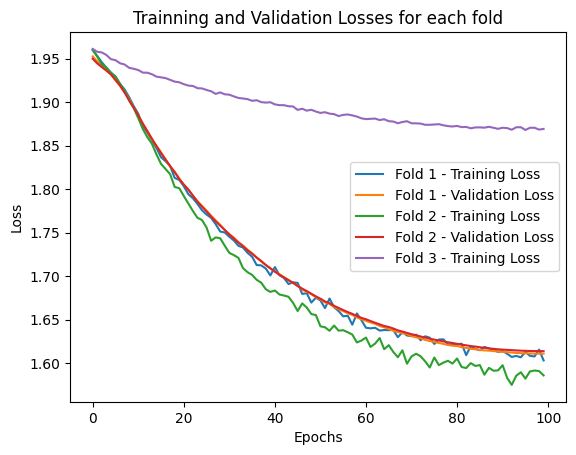

In [31]:
plot_results(all_training_losses_frozen, all_validation_losses_frozen,
             'Loss', 'Trainning and Validation Losses for each fold')

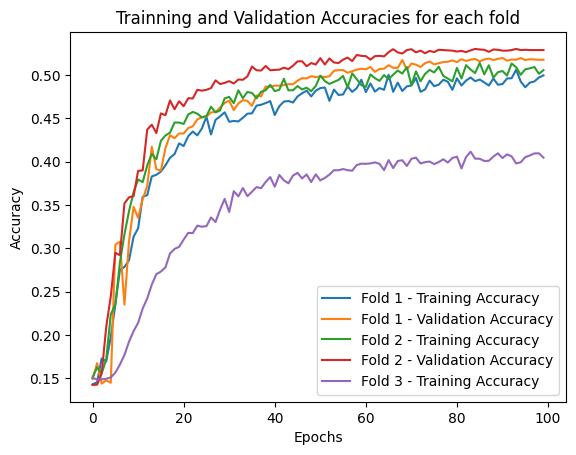

In [32]:
plot_results(all_training_accuracies_frozen, all_validation_accuracies_frozen,
             'Accuracy', 'Trainning and Validation Accuracies for each fold')

Guardamos el modelo para posteriormente hacer un entrenamiento en el que tengamos la última capa del mismo descongelado

In [33]:
model_frozen.base_model.save_pretrained(SAVE_DIRECTORY_FROZEN)

In [34]:
classifier_state_dict_path = os.path.join(
    SAVE_DIRECTORY_FROZEN, "classifier_state_dict.pt")
torch.save(model_frozen.classifier.state_dict(), classifier_state_dict_path)

Comprobamos los datos con el dataset de test para verificar divergencias

In [35]:
test_dataloader = create_dataloader(torch.tensor(test_inputs), torch.tensor(test_masks), torch.tensor(test_labels),
                                    BATCH_SIZE, device)

In [36]:
test_losses_frozen, test_accuracy_frozen, _, _ = test_model(
    model_frozen, test_dataloader, LOSS_FUNCTION)

Average test loss: 1.88, Average test accuracy: 0.42


## Ahora realizamos el entrenamiento descongelando etapas del modelo RoBERTa 

In [41]:
EPOCHS_KFOLD_UNFROZEN = 5
LEARNING_RATE_KFOLD_UNFROZEN = 5e-5
K_FOLDS_UNFROZEN = 2
LAYERS_TO_UNFREEZE = -2

In [42]:
classifier_state_dict_path = os.path.join(
    SAVE_DIRECTORY_FROZEN, "classifier_state_dict.pt")
classifier_state_dict = torch.load(classifier_state_dict_path)

base_model = RobertaModel.from_pretrained("roberta-base")
for param in base_model.encoder.layer[:LAYERS_TO_UNFREEZE].parameters():
    param.requires_grad = True

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
unfrozen_model = CustomRoBERTa(base_model.to(
    device), num_classes=len(set(df['Emotion'])))
# Load the frozen classifier state dict into the unfrozen model
unfrozen_model.classifier.load_state_dict(classifier_state_dict)
# Set the optimizer and scheduler
optimizer = torch.optim.AdamW(
    unfrozen_model.parameters(), lr=LEARNING_RATE_KFOLD_UNFROZEN)
total_steps = len(train_inputs) * EPOCHS_KFOLD_UNFROZEN
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps,
                                            num_training_steps=total_steps)

compiled_model = torch.compile(unfrozen_model)
# Perform k-fold cross-validation on the unfrozen model
kfold_results_unfrozen, model_unfrozen_last_layer = kfold_cross_validation(train_inputs, train_labels, train_masks,
                                                                           compiled_model, device,
                                                                           EPOCHS_KFOLD_UNFROZEN,
                                                                           lr=LEARNING_RATE_KFOLD_UNFROZEN,
                                                                           k_folds=K_FOLDS_UNFROZEN,
                                                                           batch_size=BATCH_SIZE,
                                                                           patience=2)

# Clear unused objects and free up memory
del unfrozen_model
torch.cuda.empty_cache()

Fold 1
Training epoch 1


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:53<00:00,  3.54it/s]


Epoch 1 - Average training loss: 1.22, Average training accuracy: 0.59
Epoch 1 - Average validation loss: 0.91, Average validation accuracy: 0.69
Training epoch 2


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 21.82it/s]


Epoch 2 - Average training loss: 0.75, Average training accuracy: 0.73
Epoch 2 - Average validation loss: 0.92, Average validation accuracy: 0.72
Training epoch 3


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 21.82it/s]


Epoch 3 - Average training loss: 0.47, Average training accuracy: 0.84
Epoch 3 - Average validation loss: 1.17, Average validation accuracy: 0.70
Early stopping triggered, no improvement for 2 consecutive epochs
Fold 2
Training epoch 1


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:53<00:00,  3.53it/s]


Epoch 1 - Average training loss: 1.19, Average training accuracy: 0.60
Epoch 1 - Average validation loss: 0.93, Average validation accuracy: 0.68
Training epoch 2


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 21.76it/s]


Epoch 2 - Average training loss: 0.71, Average training accuracy: 0.75
Epoch 2 - Average validation loss: 1.16, Average validation accuracy: 0.65
Training epoch 3


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 21.75it/s]


Epoch 3 - Average training loss: 0.42, Average training accuracy: 0.85
Epoch 3 - Average validation loss: 1.26, Average validation accuracy: 0.69
Early stopping triggered, no improvement for 2 consecutive epochs
Final Training with all data
Training epoch 1


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [01:02<00:00,  6.01it/s]


Epoch 1 - Average training loss: 1.11, Average training accuracy: 0.62
Training epoch 2


Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:17<00:00, 21.47it/s]

Epoch 2 - Average training loss: 0.69, Average training accuracy: 0.76


In [44]:
model_unfrozen_last_layer.base_model.save_pretrained(SAVE_DIRECTORY_UNFROZEN)
classifier_state_dict_path = os.path.join(
    SAVE_DIRECTORY_UNFROZEN, "classifier_state_dict.pt")
torch.save(model_unfrozen_last_layer.classifier.state_dict(),
           classifier_state_dict_path)

### Generación de la matriz de confusión, primero cargamos el modelo necesario vram muy ocupada 

In [16]:
classifier_state_dict_path = os.path.join(
    '/workspace/code/BERTS/code/RoBERTa/MODELS/RoBERTa_entrenado_kfold_unfrozen_last_layer', "classifier_state_dict.pt")
classifier_state_dict = torch.load(classifier_state_dict_path)

base_model = RobertaModel.from_pretrained("roberta-base")

model_unfrozen_last_layer = CustomRoBERTa(
    base_model.to(device), num_classes=len(set(df['Emotion'])))
# Load the frozen classifier state dict into the unfrozen model
model_unfrozen_last_layer.classifier.load_state_dict(classifier_state_dict)


model_unfrozen_last_layer = model_unfrozen_last_layer.to(device)
model_unfrozen_last_layer = torch.compile(model_unfrozen_last_layer)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
torch._dynamo.config.suppress_errors = True

In [18]:
from torch.utils.data import TensorDataset, DataLoader

# Define el tamaño del batch
batch_size = 16

# Crea un DataLoader para el conjunto de prueba
test_dataloader = create_dataloader(torch.tensor(test_inputs), torch.tensor(test_masks), torch.tensor(test_labels),
                                    BATCH_SIZE, device)
# Haz predicciones en mini-batches
preds = []
true_labels = []
model_unfrozen_last_layer.eval()
for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = batch

    # Mueve los tensores al dispositivo correcto
    b_input_ids = b_input_ids
    b_input_mask = b_input_mask
    b_labels = b_labels

    with torch.no_grad():
        outputs = model_unfrozen_last_layer(b_input_ids, b_input_mask)
        logits = outputs.logits

        _, batch_preds = torch.max(logits, dim=1)

    preds.extend(batch_preds.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())


# Obtén las categorías de tu objeto OneHotEncoder
categories = one_hot_encoder.categories_[0]

# Utiliza estas categorías para decodificar tus predicciones
preds_labels = categories[preds].reshape(-1, 1)

true_labels = one_hot_encoder.inverse_transform(true_labels)

conf_matrix = confusion_matrix(true_labels, preds_labels
                               )

print(conf_matrix)

[[ 53  23  23  32  18  42  25]
 [ 28  88  23  11  16  33  14]
 [  4  17 129   4  28  32   1]
 [ 18  11  18  67  22  41  33]
 [ 10   9  17  13 141  25   4]
 [ 10   6  20  29  32 113   7]
 [ 20  22  21  43  43  24  41]]


In [19]:
len(true_labels)/len(test_dataloader)

16.0

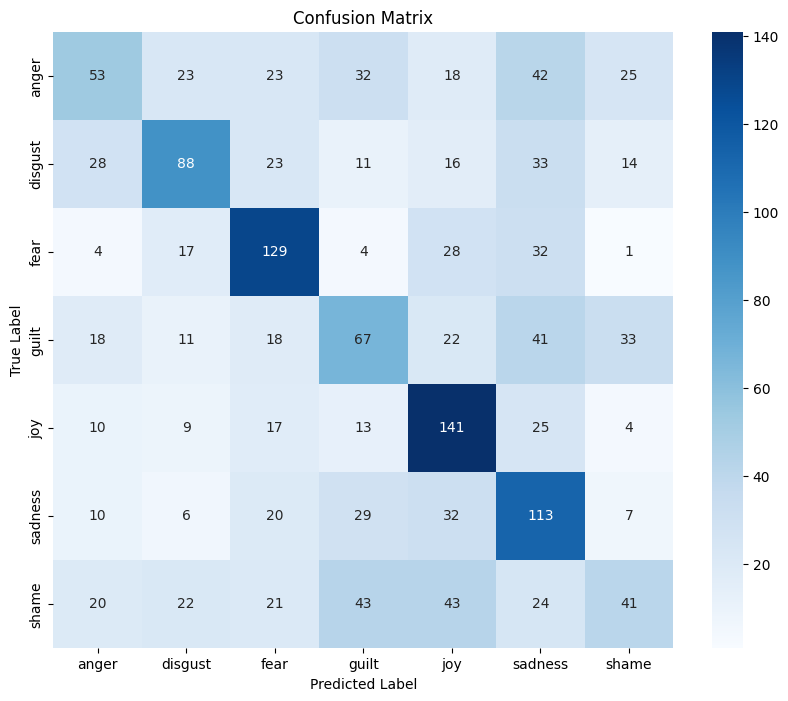

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear el dataframe para seaborn.
confusion_df = pd.DataFrame(conf_matrix, index=categories, columns=categories)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
def predict_emotion(sequence):
    # Tokeniza la secuencia
    inputs = tokenizer.encode_plus(
        sequence,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Obtiene los tensores de entrada y máscara de atención
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Evalúa la secuencia con el modelo
    with torch.no_grad():
        outputs = model_unfrozen_last_layer(input_ids, attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

    # Decodifica las predicciones
    preds_labels = np.array(categories[preds]).reshape(-1, 1)

    return preds_labels[0][0]

In [22]:
sequence = ""
emotion = predict_emotion(sequence)
print(f'The predicted emotion for "{sequence}" is {emotion}.')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


The predicted emotion for "" is sadness.


### Futuras implementaciones
Aumento de dataset, entrenamiento con modelos menos científicos para conseguir que funcione de manera más aproximada

# Adaptación para dataset más grande

In [1]:
import re
import warnings
import os
import asyncio
import traceback
from utils import *
from transformers import AutoTokenizer, RobertaModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Añadiendo las librerías necesarias para el encoding de los datos.


os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

"""GLOBAL PARAMS"""
MAX_LEN = 240
TEST_SIZE = 0.2
RANDOM_STATE = 42
EPOCHS_KFOLD_FROZEN = 100
LEARNING_RATE_KFOLD_FROZEN = 3e-4
K_FOLDS_FROZEN = 2
BATCH_SIZE = 16
LOSS_FUNCTION = nn.CrossEntropyLoss()

"DIRECTORIES"
SAVE_DIRECTORY_FROZEN = "./MODELS/RoBERTa_entrenado_kfold"
SAVE_DIRECTORY_UNFROZEN = "./MODELS/RoBERTa_entrenado_kfold_unfrozen_last_layer"

TYPED_STORAGE_WARNING = re.compile(".TypedStorage is deprecated.")
FALLBACK_KERNEL_WARNING = re.compile(".Using FallbackKernel: aten.cumsum.")
TRITON_RANDOM_WARNING = re.compile(
    ".using triton random, expect difference from eager.")


def warning_filter(message, category, filename, lineno, file=None, line=None):
    if category == UserWarning and (TYPED_STORAGE_WARNING.match(str(message)) or FALLBACK_KERNEL_WARNING.match(str(message)) or TRITON_RANDOM_WARNING.match(str(message))):
        return False
    return True


warnings.showwarning = warning_filter
warnings.filterwarnings("ignore", category=UserWarning,
                        module="torch._inductor.ir")


# Establecer la semilla para PyTorch en las operaciones CPU
torch.manual_seed(42)

# Establecer la semilla para PyTorch en las operaciones en GPU
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(42)
%matplotlib inline
%load_ext tensorboard
%tensorboard - -logdir = ./runs - -host localhost - -port 6006

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-22 22:10:16.638789: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 22:10:16.638854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 22:10:16.639914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 22:10:16.646912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to 

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-11-22 22:10:19.424138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 22:10:19.424275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 22:10:19.425278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
           

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from datasets import load_dataset

dataset_name = "RikoteMaster/Emotion_Recognition_4_llama2_chat"

ds = load_dataset(dataset_name, split="train")

In [4]:
print(ds)

In [5]:
ds['Text_processed']

['when i was on holiday with my former boyfriend he hit me and  behaved in a very evil and ugly manner in front of the hotel  personnel',
 'news of a neighbors girl going missing accompanied by the collective search efforts and the involvement of the police sparked an undeniable sense of concern and unease indicating that something untoward had likely occurred',
 'i experienced this feeling when the doctors found a nodule in one  of my mothers breasts it turned out to be an occlusion  resulting from continious sucking but for a few days i was not in my  reason',
 'i experienced a strong surge of displeasure towards someone a feeling that stirred within me a deep sense of frustration and disappointment',
 'when the realization dawned upon me that i was unable to establish effective communication with my dearest friend a profound sense of melancholy settled within me',
 'i was made a very sharp remark at a rehearsal',
 'a truck big one nearly mowed me off the road i was driving a  small 

In [6]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Tokenize and encode the input data
tokenized_features = tokenizer.batch_encode_plus(ds['Text_processed'], add_special_tokens=True,
                                                 padding='max_length', truncation=True,
                                                 max_length=MAX_LEN, return_attention_mask=True,
                                                 return_tensors='pt'
                                                 )

In [7]:
one_hot_encoder = OneHotEncoder()
target_one_hot = one_hot_encoder.fit_transform(
    np.array(ds['Emotion']).reshape(-1, 1)).toarray()

In [8]:
print(target_one_hot.shape)

(63, 7)

In [9]:
print(tokenized_features.keys())

dict_keys(['input_ids', 'attention_mask'])

In [10]:
train_inputs = tokenized_features['input_ids']
train_masks = tokenized_features['attention_mask']
train_labels = target_one_hot

In [11]:
print(train_inputs.shape, train_masks.shape, train_labels.shape)

torch.Size([63, 240]) torch.Size([63, 240]) (63, 7)


In [12]:
base_model = RobertaModel.from_pretrained("roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
for param in base_model.parameters():
    param.requires_grad = False

    # Initialize the custom RoBERTa model
model = CustomRoBERTa(base_model.to(device), num_classes=len(set(ds['Emotion'])))

In [14]:
compiled_model = torch.compile(model)

In [15]:
optimizer = torch.optim.AdamW(compiled_model.parameters(), LEARNING_RATE_KFOLD_FROZEN)

In [16]:
total_steps = len(train_inputs) * EPOCHS_KFOLD_FROZEN
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps,
                                            num_training_steps=total_steps)

In [17]:
kfold_results, model_frozen = kfold_cross_validation(train_inputs, train_labels, train_masks, compiled_model, device, EPOCHS_KFOLD_FROZEN, lr=LEARNING_RATE_KFOLD_FROZEN,
                                                     k_folds=1,
                                                     batch_size=BATCH_SIZE)

Using 80% of dataset for trainning and 20% for validation
tensor([[    0,   118,    56,  ...,     1,     1,     1],
        [    0, 22466,   983,  ...,     1,     1,     1],
        [    0,   102,   181,  ...,     1,     1,     1],
        ...,
        [    0,   118,  2145,  ...,     1,     1,     1],
        [    0,  4783,  1144,  ...,     1,     1,     1],
        [    0,   118,  2984,  ...,     1,     1,     1]], device='cuda:0') tensor([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.

Iteration: 100%|█████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.15s/it]


Epoch 1 - Average training loss: 1.88, Average training accuracy: 0.17
Epoch 1 - Average validation loss: 1.97, Average validation accuracy: 0.08
Training epoch 2


Iteration: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 65.89it/s]


Epoch 2 - Average training loss: 1.88, Average training accuracy: 0.19
Epoch 2 - Average validation loss: 1.96, Average validation accuracy: 0.08
Training epoch 3


Iteration: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 66.35it/s]


Epoch 3 - Average training loss: 1.92, Average training accuracy: 0.20
Epoch 3 - Average validation loss: 1.96, Average validation accuracy: 0.15
Training epoch 4


Iteration: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 67.53it/s]


Epoch 4 - Average training loss: 1.92, Average training accuracy: 0.17
Epoch 4 - Average validation loss: 1.96, Average validation accuracy: 0.15
Training epoch 5


Iteration: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 74.15it/s]


Epoch 5 - Average training loss: 1.90, Average training accuracy: 0.25
Epoch 5 - Average validation loss: 1.96, Average validation accuracy: 0.15
Training epoch 6


Iteration: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 78.00it/s]


Epoch 6 - Average training loss: 1.91, Average training accuracy: 0.33
Epoch 6 - Average validation loss: 1.96, Average validation accuracy: 0.15
Training epoch 7


Iteration: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 78.18it/s]


Epoch 7 - Average training loss: 1.90, Average training accuracy: 0.23
Epoch 7 - Average validation loss: 1.96, Average validation accuracy: 0.15
Training epoch 8


Iteration: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 78.24it/s]


Epoch 8 - Average training loss: 1.92, Average training accuracy: 0.36
Epoch 8 - Average validation loss: 1.96, Average validation accuracy: 0.15
Training epoch 9


Iteration: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 77.97it/s]


Epoch 9 - Average training loss: 1.88, Average training accuracy: 0.34
Epoch 9 - Average validation loss: 1.96, Average validation accuracy: 0.15
Training epoch 10


Iteration: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 78.01it/s]


Epoch 10 - Average training loss: 1.91, Average training accuracy: 0.20
Epoch 10 - Average validation loss: 1.96, Average validation accuracy: 0.15


In [23]:
for i, fold_result in enumerate(kfold_results):
    message = f"Fold {i + 1} results (frozen model):\nAccuracy: {fold_result['validation_accuracies'][-1]:.4f}\nLoss: {fold_result['validation_losses'][-1]:.4f}"
    print(message)

Fold 1 results (frozen model):
Accuracy: 0.1538
Loss: 1.9576


In [24]:
all_training_losses_frozen = []
all_training_accuracies_frozen = []
all_validation_losses_frozen = []
all_validation_accuracies_frozen = []

# Iterate through the results of each fold
for fold_result in kfold_results:
    all_training_losses_frozen.append(fold_result['training_losses'])
    all_training_accuracies_frozen.append(fold_result['training_accuracies'])
    all_validation_losses_frozen.append(fold_result['validation_losses'])
    all_validation_accuracies_frozen.append(
        fold_result['validation_accuracies'])

In [30]:
print(all_training_losses_frozen, all_training_accuracies_frozen)

[[1.8833640459924936, 1.8846260029822588, 1.9182456005364656, 1.9162900354713202, 1.9020306002348661, 1.9063410107046366, 1.9041474256664515, 1.918266724795103, 1.8839017879217863, 1.912987869232893]] [[0.171875, 0.1875, 0.203125, 0.171875, 0.25, 0.328125, 0.234375, 0.359375, 0.34375, 0.203125]]


In [31]:
import os
import matplotlib.pyplot as plt

def plot_and_save_results(training_losses, validation_losses, metric, title, file_name):
    # Create the directory ./Results if it does not exist
    if not os.path.exists('./Results'):
        os.makedirs('./Results')
    
    # Create a new figure
    plt.figure()
    
    # Check if losses are a list of lists (multiple folds)
    if all(isinstance(loss, list) for loss in training_losses):
        # Plot the loss or accuracy curve for training for each fold
        for i, losses in enumerate(training_losses):
            plt.plot(losses, label=f'Training {metric} Fold {i+1}')
        # Plot the loss or accuracy curve for validation for each fold
        for i, losses in enumerate(validation_losses):
            plt.plot(losses, label=f'Validation {metric} Fold {i+1}')
    else:
        # Plot the loss or accuracy curve for training
        plt.plot(training_losses, label=f'Training {metric}')
        # Plot the loss or accuracy curve for validation if available
        if validation_losses is not None:
            plt.plot(validation_losses, label=f'Validation {metric}')

    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.title(title)
    
    # Save the figure in the directory ./Results with the provided name
    plt.savefig(f'./Results/{file_name}.png')
    
    # Close the figure to free up memory
    plt.close()

# Example usage of the function
plot_and_save_results(
    all_training_losses_frozen, 
    all_validation_losses_frozen,
    'Loss', 
    'Training and Validation Losses', 
    'training_validation_loss'
)


[{'training_losses': [1.8833640459924936,
   1.8846260029822588,
   1.9182456005364656,
   1.9162900354713202,
   1.9020306002348661,
   1.9063410107046366,
   1.9041474256664515,
   1.918266724795103,
   1.8839017879217863,
   1.912987869232893],
  'training_accuracies': [0.171875,
   0.1875,
   0.203125,
   0.171875,
   0.25,
   0.328125,
   0.234375,
   0.359375,
   0.34375,
   0.203125],
  'validation_losses': [1.9710313081741333,
   1.964587505047138,
   1.9607437482246988,
   1.9584508308997521,
   1.9575805755761955,
   1.9575805755761955,
   1.9575805755761955,
   1.9575805755761955,
   1.9575805755761955,
   1.9575805755761955],
  'validation_accuracies': [0.07692307692307693,
   0.07692307692307693,
   0.15384615384615385,
   0.15384615384615385,
   0.15384615384615385,
   0.15384615384615385,
   0.15384615384615385,
   0.15384615384615385,
   0.15384615384615385,
   0.15384615384615385]}]

In [32]:
model_frozen.base_model.save_pretrained(SAVE_DIRECTORY_FROZEN)

In [33]:
classifier_state_dict_path = os.path.join(
    SAVE_DIRECTORY_FROZEN, "classifier_state_dict.pt")
classifier_state_dict = torch.load(classifier_state_dict_path)
